In [1]:
import numpy as np  
import pandas as pd
from pathlib import Path
from fastai.text.all import *

In [2]:
### Load data
df = pd.read_csv('labelled_nostr_events_20230225000.csv').dropna();
df.head()

,label,text
0,ham,"gosta mais de ""o anti"" é?\n"
1,ham,Yo! What are y’all working on?
2,ham,We are Damus volunteers. You can choose to follow me and check my previous pictures and texts to get the answers you want.\nThe node you want\nthese are the most important relays:\nDamus:\nwss://relay.damus.io\nwss://eden.nostr.land\nwss://relay.snort.social\nwss://nostr.orangepill.dev\nwss://nos.lol\nwss://relay.current.fyi\nwss://brb.io\n\nAmethyst:\nwss://nostr.bitcoiner.social\nwss://relay.nostr.bg\nwss://brb.io\nwss://relay.snort.social\nwss://nostr.rocks\nwss://relay.damus.io\nwss://nostr.fmt.wiz.biz\nwss://nostr.oxtr.dev\nwss://eden.nostr.land\nwss://nostr-2.zebedee.cloud\nwss://nos...
3,ham,"I assume it was regulatory issues. This is the ""easier"" route? And here we are using Lightning..."
4,ham,proof of #nostrchain\n\nhttps://nostr.build/i/4976.png


In [3]:
### Part 1: Training for next word as our base language model

In [4]:
dls_lm = TextDataLoaders.from_df(df, 
                                 text_col = 'text', 
                                 label_col = 'label', 
                                 valid_pct = 0.10, 
                                 bs = 64, 
                                 is_lm = True)

In [5]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3, metrics=accuracy)

SuggestedLRs(valley=0.007585775572806597)

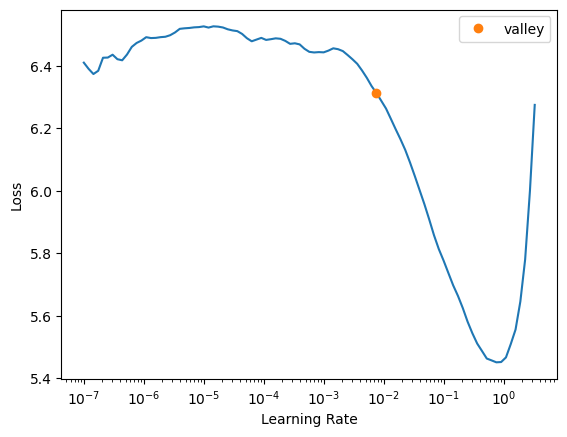

In [6]:
# Estimate the best learning rate to prevent over-fitting
learn.lr_find()

In [7]:
### Note: This part can be really slow - you can stop after 2 epochs instead of 5
learn.fit_one_cycle(5, 2e-3)


epoch,train_loss,valid_loss,accuracy,time
0,3.653843,3.333879,0.463396,32:25
1,2.837590,2.817935,0.524825,29:52
2,2.621461,2.707692,0.537485,34:18
3,2.557360,2.673841,0.541284,36:31
4,2.529439,2.668449,0.541483,39:07


In [8]:
learn.save_encoder('language_model')

In [9]:
### Part 2: Training for categorisation (spam or ham)

In [10]:
dls_clas = TextDataLoaders.from_df(df,
                        valid_pct = 0.10, 
                        text_col = 'text',
                        label_col = 'label', 
                        bs = 64, 
                        text_vocab = dls_lm.vocab)

In [11]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult = 0.5, metrics = accuracy)

In [12]:
# Load our saved encoder into the new categorisation model
learn = learn.load_encoder('language_model')

SuggestedLRs(valley=0.007585775572806597)

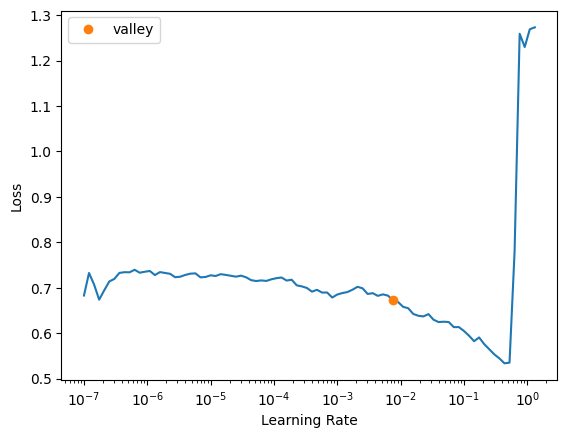

In [13]:
# Estimate the best learning rate to prevent over-fitting
learn.lr_find()

In [14]:
### Note: This part can be slow
learn.fit_one_cycle(2, 0.0075857)

epoch,train_loss,valid_loss,accuracy,time
0,0.112077,0.105942,0.975712,19:56
1,0.084099,0.073005,0.977655,18:39


In [15]:
### Note: This part can be slow (more training)
learn.freeze_to(-2)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.080537,0.082195,0.976252,23:11
1,0.057797,0.071176,0.980786,19:51
2,0.066811,0.064572,0.981218,18:06


In [16]:
learn.freeze()

In [17]:
### Exporting the model

In [18]:
learn.export('models/awd_lstm_fully_trained_export')

In [19]:
### Loading the model

In [20]:
learn = load_learner('models/awd_lstm_fully_trained_export')

In [21]:
learn.predict('It was snow day in Tokyo. I\'m always at outside during work so that was awful. Do you like snow? Speaking of snow, I remembered "informer" though...🤔')

('ham', tensor(0), tensor([9.9997e-01, 2.9246e-05]))

In [22]:
learn.predict('打扰大家了，打个广告！S9是一个可帮助社区代币销毁的平台 平台资金雄厚，持有国际牌照！ 注意事项：目前只开放海外用户，请开启境外VPN访问！ 官方网址: https://s9.com TG群: https://t.me/S9Coin_cn https://s9app.net/ZcTzak.png')

('spam', tensor(1), tensor([0.0037, 0.9963]))